In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
import io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [4]:
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [5]:
DEVICE = set_device()

In [6]:
torch.manual_seed(180401051)

In [7]:
uploaded = files.upload()

Saving cure_the_princess_test.csv to cure_the_princess_test.csv
Saving cure_the_princess_train.csv to cure_the_princess_train.csv
Saving cure_the_princess_validation.csv to cure_the_princess_validation.csv


In [8]:
train_data = pd.read_csv(io.BytesIO(uploaded['cure_the_princess_train.csv']))
train_labels = train_data.iloc[:, -1]
train_data = train_data.iloc[:, :-1]

val_data = pd.read_csv(io.BytesIO(uploaded['cure_the_princess_validation.csv']))
val_labels = val_data.iloc[:, -1]
val_data = val_data.iloc[:, :-1] 

test_data = pd.read_csv(io.BytesIO(uploaded['cure_the_princess_test.csv']))
test_labels = test_data.iloc[:, -1]
test_data = test_data.iloc[:, :-1]

In [9]:
# Örnek bir dataset sınıfı oluşturalım
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.Tensor(data.values)
        self.labels = torch.Tensor(labels.values.reshape(-1, 1))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [14]:
# Data loader'ları tanımlayalım
batch_size =32
train_dataset = MyDataset(train_data, train_labels)
val_dataset = MyDataset(val_data, val_labels)
test_dataset = MyDataset(test_data, test_labels)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

In [31]:
# Modelimizi tanımlayalım
input_size = 13
hidden_size1 = 100
hidden_size2 = 50
output_size = 1
learning_rate = 0.001
epochs = 100
patience=10

model = MLP(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

Epoch: 10/100, Train Loss: 0.4332, Val Loss: 0.3859
Epoch: 20/100, Train Loss: 0.3472, Val Loss: 0.2944
Epoch: 30/100, Train Loss: 0.3172, Val Loss: 0.2506
Epoch: 40/100, Train Loss: 0.2870, Val Loss: 0.2575
Epoch: 50/100, Train Loss: 0.2554, Val Loss: 0.2140
Epoch: 60/100, Train Loss: 0.2421, Val Loss: 0.2293
Epoch: 70/100, Train Loss: 0.2288, Val Loss: 0.1955
Epoch: 80/100, Train Loss: 0.2176, Val Loss: 0.1900
Epoch: 90/100, Train Loss: 0.2314, Val Loss: 0.2923
Epoch: 100/100, Train Loss: 0.1922, Val Loss: 0.1761


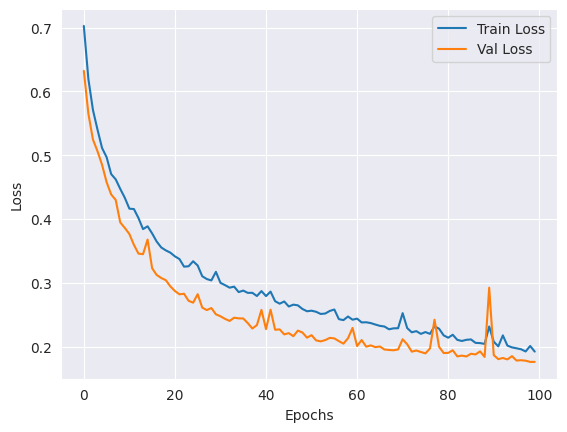

In [32]:
#def train(model, train_dataloader, val_dataloader, criterion, optimizer, epochs):
train_losses = []
val_losses = []
best_model = None
best_val_loss= float('inf')
patience_counter = 0
for epoch in range(epochs):
        # Training
    model.train()
    train_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

        # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)

    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping: val_loss has not improved for {patience} epochs')
            break


sns.set_style("darkgrid")
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#train(model, train_dataloader, val_dataloader, criterion, optimizer, epochs)

In [49]:
tp = 0  # True positives
fp = 0  # False positives
tn = 0  # True negatives
fn = 0  # False negatives
best_model.eval()
with torch.no_grad():
      for i, (inputs, labels) in enumerate(val_dataloader):
              outputs = best_model(inputs.float())
              loss = criterion(outputs, labels)
              val_loss += loss.item()
val_loss /= len(val_dataloader)
val_losses.append(val_loss)
predicted_labels = (outputs >= 0.5).float()

            # matrisi güncelliyorum
tp += torch.sum(predicted_labels * labels).item()
fp += torch.sum(predicted_labels * (1 - labels)).item()
tn += torch.sum((1 - predicted_labels) * (1 - labels)).item()
fn += torch.sum((1 - predicted_labels) * labels).item()

    # Compute accuracy, precision, recall and F1 score
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)

print(f'Test Accuracy: {accuracy:.4f}, Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1: {f1:.4f}')

Test Accuracy: 0.9231, Test Precision: 0.8824, Test Recall: 1.0000, Test F1: 0.9375
